In [4]:
import shutil, glob, os

for file in glob.glob('a/*'):
    shutil.copy(file, f'b/{file.split(os.sep)[-1]}')

In [5]:
import torch
from torch import nn
from torch.nn import functional as F


support = torch.linspace(-10, 10, 10)

q = torch.zeros(10)
q[7]=2

q = F.softmax(q,-1)

q, (q*support).sum()

(tensor([0.0610, 0.0610, 0.0610, 0.0610, 0.0610, 0.0610, 0.0610, 0.4509, 0.0610,
         0.0610]),
 tensor(2.1658))

In [6]:
a=torch.tensor([1,0,-1])
a!=-1

tensor([ True,  True, False])

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import time

import math

from nosaveddata import *


def renormalize(tensor, has_batch=False):
    shape = tensor.shape
    tensor = tensor.view(tensor.shape[0], -1)
    max_value,_ = torch.max(tensor, -1, keepdim=True)
    min_value,_ = torch.min(tensor, -1, keepdim=True)
    return ((tensor - min_value) / (max_value - min_value + 1e-5)).view(shape)


class DQN(nn.Module):
    def __init__(self, n_actions, hiddens=2048, mlp_layers=1, scale_width=4,
                 n_atoms=51, Vmin=-10, Vmax=10):
        super().__init__()
        self.support = torch.linspace(Vmin, Vmax, n_atoms).cuda()
        
        self.hiddens=hiddens
        self.scale_width=scale_width
        self.act = nn.ReLU()
        
        
        self.encoder_cnn = IMPALA_Resnet(scale_width=scale_width, norm=False, init=init_xavier, act=self.act)
        
        

        # Single layer dense that maps the flattened encoded representation into hiddens.
        self.projection = MLP(13824, med_hiddens=hiddens, out_hiddens=hiddens,
                              last_init=init_xavier, layers=1)
        self.prediction = MLP(hiddens, out_hiddens=hiddens, layers=1, last_init=init_xavier)
                                              
        self.transition = nn.Sequential(DQN_Conv(32*scale_width+n_actions, 32*scale_width, 3, 1, 1, norm=False, init=init_xavier, act=self.act),
                                        DQN_Conv(32*scale_width, 32*scale_width, 3, 1, 1, norm=False, init=init_xavier, act=self.act))

        self.reward_mlp = MLP(hiddens, out_hiddens=1, layers=1, last_init=init_xavier)

        # Single layer dense that maps hiddens into the output dim according to:
        # 1. https://arxiv.org/pdf/1707.06887.pdf -- Distributional Reinforcement Learning
        # 2. https://arxiv.org/pdf/1511.06581.pdf -- Dueling DQN
        self.a = MLP(hiddens, out_hiddens=n_actions*num_buckets, layers=1, in_act=self.act, last_init=init_xavier)
        self.v = MLP(hiddens, out_hiddens=num_buckets, layers=1, in_act=self.act, last_init=init_xavier)
    
        params_count(self, 'DQN')
    
    def forward(self, X, y_action):
        X, z = self.encode(X)
        
        
        q, action = self.q_head(X)
        z_pred = self.get_transition(z, y_action)

        reward_pred = self.reward_mlp(z_pred)

        return q, action, X[:,1:].clone().detach(), z_pred, reward_pred
    
    def get_root(self, X):
        X, z = self.encode(X)
        q, action = self.q_head(X)

        return z, q.squeeze(-3)

    def get_Q_last_state(self, z):
        z = self.projection(z.flatten(-3,-1)).view(self.batch,-1)
        z = self.prediction(z)

        
        q, action = self.q_head(z)

        action = action[:,:,None,None].expand_as(q)[:,:,0][:,:,None]
        q = q.gather(-2,action)
        
        return (q.squeeze()*self.support).sum(-1)
    
    def env_step(self, X):
        with torch.no_grad():
            X, _ = self.encode(X)
            _, action = self.q_head(X)
            
            return action.detach()
    

    def encode(self, X):
        batch, seq = X.shape[:2]
        self.batch = batch
        self.seq = seq
        X = self.encoder_cnn(X.contiguous().view(self.batch*self.seq, *(X.shape[2:])))
        X = renormalize(X).contiguous().view(self.batch, self.seq, *X.shape[-3:])
        X = X.contiguous().view(self.batch, self.seq, *X.shape[-3:])
        z = X.clone()
        X = X.flatten(-3,-1)
        X = self.projection(X)
        return X, z

    def transition_one_step(self, z, action):
        self.batch = z.shape[0]
        z = z.contiguous().view(-1, *z.shape[-3:])
        
        action = F.one_hot(action.clone(), n_actions).view(-1, n_actions)
        action = action.view(-1, n_actions, 1, 1).expand(-1, n_actions, *z.shape[-2:])

        #print(f"transition_one_step {z.shape, action.shape}")
        z_pred = torch.cat( (z, action), 1)
        z_pred = self.transition(z_pred)
        z_transition = renormalize(z_pred)
        
        z_pred = self.projection(z_transition.flatten(-3,-1)).view(self.batch,-1)
        z_pred = self.prediction(z_pred)

        
        q = self.dueling_dqn(z_pred).squeeze(-3)
        action = (q*self.support).sum(-1).argmax(-1)
        
        reward_pred = self.reward_mlp(z_pred)
        
        return z_transition, q, reward_pred.squeeze(-1)
        
    def get_transition(self, z, action):
        z = z.contiguous().view(-1, *z.shape[-3:])
        
        action = F.one_hot(action.clone(), n_actions).view(-1, n_actions)
        action = action.view(-1, 5, n_actions, 1, 1).expand(-1, 5, n_actions, *z.shape[-2:])

        z_pred = torch.cat( (z, action[:,0]), 1)
        z_pred = self.transition(z_pred)
        z_pred = renormalize(z_pred)
        
        z_preds=[z_pred.clone()]
        

        for k in range(4):
            z_pred = torch.cat( (z_pred, action[:,k+1]), 1)
            z_pred = self.transition(z_pred)
            z_pred = renormalize(z_pred)
            
            z_preds.append(z_pred)
        
        
        z_pred = torch.stack(z_preds,1)

        z_pred = self.projection(z_pred.flatten(-3,-1)).view(self.batch,5,-1)
        z_pred = self.prediction(z_pred)
        
        return z_pred

    
    def q_head(self, X):
        q = self.dueling_dqn(X)
        action = (q*self.support).sum(-1).argmax(-1)
        
        return q, action

    def get_max_action(self, X):
        with torch.no_grad():
            X, _ = self.encode(X)
            q = self.dueling_dqn(X)
            
            action = (q*self.support).sum(-1).argmax(-1)
            return action

    def evaluate(self, X, action):
        with torch.no_grad():
            X, _ = self.encode(X)
            
            q = self.dueling_dqn(X)
            
            action = action[:,:,None,None].expand_as(q)[:,:,0][:,:,None]
            q = q.gather(-2,action)
            
            return q

    def dueling_dqn(self, X):
        X = F.relu(X)
        
        a = self.a(X).view(self.batch, -1, n_actions, num_buckets)
        v = self.v(X).view(self.batch, -1, 1, num_buckets)
        
        q = v + a - a.mean(-2,keepdim=True)
        q = F.softmax(q,-1)
        
        return q
    
    def network_ema(self, rand_network, target_network, alpha=0.5):
        for param, param_target in zip(rand_network.parameters(), target_network.parameters()):
            param_target.data = alpha * param_target.data + (1 - alpha) * param.data.clone()

    def hard_reset(self, random_model, alpha=0.5):
        with torch.no_grad():
            
            self.network_ema(random_model.encoder_cnn, self.encoder_cnn, alpha)
            self.network_ema(random_model.transition, self.transition, alpha)

            self.network_ema(random_model.projection, self.projection, 0)
            self.network_ema(random_model.prediction, self.prediction, 0)
            self.network_ema(random_model.reward_mlp, self.reward_mlp, 0)

            self.network_ema(random_model.a, self.a, 0)
            self.network_ema(random_model.v, self.v, 0)


num_buckets = 51
n_actions = 7

model = DQN(n_actions).cuda()

C:\Users\sneep\anaconda3\envs\python_\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sneep\anaconda3\envs\python_\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


IMPALA ResNet Parameters: 1.56M
DQN Parameters: 35.21M


In [10]:


class MCTS_Node(nsd_Module):
    def __init__(self, z, Q, reward, prev_state, n_actions, hiddens=2048, batch_size=3):
        super().__init__()
        
        self.transitions = [None]*self.n_actions
        
        self.n = torch.zeros(n_actions, device='cuda')
        
        self.p = F.softmax(Q,-1)
        self.Q_sa = Q
        self.Q = torch.zeros_like(Q)

        self.choosen_action = torch.tensor(-1, device='cuda', dtype=torch.long)
        
        
    def reset_n(self):
        self.n = torch.zeros(self.n_actions, device='cuda')
    
    def get_stats(self):

        return self.Q, self.Q_sa, self.z, self.p, self.n, self.reward, self.choosen_action
        
    def forward(self, x):

        return x


class MCTS(nsd_Module):
    def __init__(self, n_actions, k=5, batch_size=3, n_sim=16, topk_actions=8, c_visit=50, c_scale=0.1):
        # Good c_scale values are 0.1 and 1
        super().__init__()
        self.topk_actions = torch.tensor(topk_actions)
    

    def get_root(self, model, x):
        z, Q = model.get_root(x)
        Q = (Q*model.support).sum(-1)
        #print(f"{z.shape, Q.shape}")
        nodes = []
        for i in range(Q.shape[0]):
            root = MCTS_Node(z[i], Q[i], torch.tensor([0]*self.batch_size).cuda()[i], prev_state=None, n_actions=self.n_actions, batch_size=self.batch_size)
            nodes.append(root)
        self.root = nodes
        return self.root

    def collate_nodes(self):
        Q, Q_sa, Z, P, N, R, A = [], [], [], [], [], [], []
        for node in self.cur_state:
            q, q_sa, z, p, n, r, a = node.get_stats()
            Q.append(q)
            Q_sa.append(q_sa)
            Z.append(z)
            P.append(p)
            N.append(n)
            R.append(r)
            A.append(a)
        return torch.stack(Q,0), torch.stack(Q_sa,0), torch.stack(Z,0), torch.stack(P,0), torch.stack(N,0), torch.stack(R,0), torch.stack(A,0)
    
    def transition(self, model, x, action):
        
        z, Q, reward_pred = model.transition_one_step(x, action)
        Q = (Q*model.support).sum(-1)
        #print(f"{Q.shape, reward_pred.shape}")
    
        nodes = []
        
        for i in range(Q.shape[0]):
            if self.cur_state[i].transitions[action[i]] == None:
                node = MCTS_Node(z[i], Q[i], reward_pred[i], prev_state=self.cur_state[i], n_actions=self.n_actions, batch_size=self.batch_size)
                nodes.append(node)
                self.cur_state[i].transitions[action[i]] = node
            else:
                nodes.append(self.cur_state[i].transitions[action[i]])
                

        return nodes

    
    def backup(self, model):
        
        Q, Q_sa, z, p, n, r_t, choosen_action = self.collate_nodes()
        
        next_values = model.get_Q_last_state(z)#[:,None]

        rewards = [r_t]
        gammas = torch.ones(self.batch_size, self.k, device='cuda')*0.997
        

        for i in range(len(self.cur_state)):
            self.cur_state[i] = self.cur_state[i].prev_state
            

        for l in range(self.k):
            Q, Q_sa, z, p, n, r_t, choosen_action = self.collate_nodes()
            
            r = torch.stack(list(reversed(rewards)), -1)

            returns = (r*gammas[:,:l+1].cumprod(-1)).sum(-1) + next_values*(gammas[:,:l+1].prod(-1))
            #print(f"backup returns {returns.shape}")
            #print(f"n choosen action {n}\n{choosen_action}\n")
            
            n_action = n[torch.arange(self.batch_size), choosen_action]
            

            Q[torch.arange(self.batch_size), choosen_action] = (n_action*Q[torch.arange(self.batch_size),choosen_action] + returns) / (n_action+1)
            
            n[torch.arange(self.batch_size), choosen_action] += 1

            
            
            rewards.append(r_t)
            
            for i in range(len(self.cur_state)):
                self.cur_state[i].Q = Q[i]
                self.cur_state[i].n = n[i]
                
                self.cur_state[i] = self.cur_state[i].prev_state
                
        
    def forward(self, model, x):

        self.cur_state = self.get_root(model, x)

        q_sa = self.collate_nodes()[1]
        gumbel = F.gumbel_softmax(torch.zeros_like(q_sa))
        gumbel_sa = gumbel+q_sa
        print(f"GUMBEL & Q_sa {gumbel_sa}\n{q_sa}\n\n")

        k = min(self.topk_actions, self.n_actions)
        
        Q_mask = F.one_hot(gumbel_sa.topk(k)[1], self.n_actions).sum(-2)

        
        

        halve_sims = self.n_sim//2
        halves = 2

        next_halve = math.floor(self.n_sim/(torch.log2(self.topk_actions)*(self.topk_actions)))
        
        for sim in range(self.n_sim):
            actions_to_step = []
            for l in range(self.k):
                q, q_sa, z, p, n, _, _ = self.collate_nodes()
                
                if l==0 and sim==next_halve:
                    print(f"gumbel q {gumbel_sa.shape, q.shape, n.shape}")
                    gumbel_sa = gumbel + q_sa
                    k = min(self.topk_actions//halves*2, self.n_actions)
                    print(f"ACTION AMMOUNT IS HEREBYRAUBIESUYRBAESYUI {k}")
                    
                    Q_mask = F.one_hot(gumbel_sa.topk(k)[1], self.n_actions).sum(-2)
                    print(f"TOPK K ACTIONS {gumbel_sa.topk(k)[1]}")
                    
                    #Q_mask = gumbel_sa + (self.c_visit + n.max(-1)[0])*self.c_scale*q
                    #Q_mask = F.one_hot(gumbel_sa.topk(self.topk_actions//halves)[1], self.n_actions).sum(-2)
                    
                    print(f"HALVE SIM {Q_mask.shape, n.shape}")

                    next_halve += math.floor(self.n_sim/(torch.log2(self.topk_actions)*(self.topk_actions/(halves*2))))
                    print(f"next_halve {next_halve}")
                    
                    halves*=2

                if l==0:
                    
                    #print(f"gumel n q {gumbel_sa.shape, n.max(-1)[0].shape, q.shape}")
                    Q = gumbel_sa + (self.c_visit + n.max(-1)[0][:,None])*self.c_scale*q
                    print(f"Q Mask {Q, Q_mask}")
                    #print(f"{n}")

                    action = (Q*Q_mask).argmax(-1) # Gumbel top-k
                    
                else:
                    completed_Q = (n==0)*q_sa + (n>0)*q
                    
                    completed_Q = (self.c_visit + n.max(-1)[0][:,None])*self.c_scale*completed_Q
                    
                    
                    improved_policy = F.softmax((q_sa+completed_Q),-1)

                    
                    #print(f"{improved_policy.shape, (n/(1+n.sum(-1)[:,None])).shape}")
                    Q = improved_policy - n/(1+n.sum(-1)[:,None])
                    
                    action = Q.argmax(-1)
                    #print(f"l and action: {l} {action}")

                
                
                
                actions_to_step.append(Q.argmax(-1))
                
                
                for i in range(len(self.cur_state)):
                    self.cur_state[i].choosen_action = action[i]
                    
                self.cur_state = self.transition(model, z, action)
                
            self.backup(model)
            self.cur_state = self.root
            print(f"\n\n")
        
        Q = self.collate_nodes()[0]
        return Q/self.n_sim, Q.argmax(-1), actions_to_step


mcts = MCTS(n_actions=7, n_sim=16, topk_actions=8, batch_size=3)



#x = torch.randn(3,128,12,9).cuda()
#actions = torch.randint(0, n_actions, (x.shape[0],)).cuda()

#q, next_state = model.transition_one_step(x, actions)

x = torch.randn(3,1,12,96,72).cuda()

#print(f"{q.shape, next_state.shape}")
Q, act, _ = mcts(model, x)
Q#.shape, act.shape

GUMBEL & Q_sa tensor([[-0.2536, -0.4209, -0.0024, -0.7191, -0.0036, -0.0155, -0.3478],
        [ 0.0752, -0.5040, -0.4156, -0.5600,  0.2159, -0.0634, -0.3638],
        [-0.1573, -0.3986, -0.3678, -0.5914,  0.6631,  0.0274, -0.3696]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[-0.4036, -0.5291, -0.5031, -0.7707, -0.0362, -0.1193, -0.4009],
        [-0.3582, -0.5717, -0.4956, -0.7085,  0.0107, -0.0842, -0.4084],
        [-0.2964, -0.4439, -0.4410, -0.6243,  0.0063, -0.0127, -0.3822]],
       device='cuda:0', grad_fn=<StackBackward0>)


gumbel q (torch.Size([3, 7]), torch.Size([3, 7]), torch.Size([3, 7]))
ACTION AMMOUNT IS HEREBYRAUBIESUYRBAESYUI 7
TOPK K ACTIONS tensor([[2, 4, 5, 0, 6, 1, 3],
        [4, 0, 5, 6, 2, 1, 3],
        [4, 5, 0, 2, 6, 1, 3]], device='cuda:0')
HALVE SIM (torch.Size([3, 7]), torch.Size([3, 7]))
next_halve 2
Q Mask (tensor([[-0.2536, -0.4209, -0.0024, -0.7191, -0.0036, -0.0155, -0.3478],
        [ 0.0752, -0.5040, -0.4156, -0.5600,  0.2159, -0.0634

tensor([[0.0000, 0.0000, 0.3537, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3605, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2983, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [49]:
torch.tensor([-1,0,1,2,3,4,5]).max(-1)[0], torch.tensor([-1,0,1,2,3,4,5]).topk(3)[1]

(tensor(5), tensor([6, 5, 4]))

In [10]:
import math
math.ceil(7/2)

4

In [98]:
torch.tensor([-1,2]).max(-1)[0]

tensor(2)

In [42]:
0.995**(4/1)

0.980149500625

In [48]:
a = torch.randn(3)
a, F.gumbel_softmax(torch.zeros_like(a))+a, F.softmax(a)

C:\Users\sneep\AppData\Local\Temp\ipykernel_8868\3376276355.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a, F.gumbel_softmax(torch.zeros_like(a))+a, F.softmax(a)


(tensor([ 0.2252, -1.0917,  1.4278]),
 tensor([ 0.2898, -0.1902,  1.4617]),
 tensor([0.2175, 0.0583, 0.7242]))

In [23]:
def a(p):
    return p.pop(0)

c = [1,2,3]

a(c), c

(1, [2, 3])

In [19]:
num_envs=1
model.env_step(x).view(num_envs).squeeze(0)

tensor(12, device='cuda:0')

In [38]:
def project_distribution(supports, weights, target_support):
    with torch.no_grad():
        v_min, v_max = target_support[0], target_support[-1]
        # `N` in Eq7.
        num_dims = target_support.shape[-1]
        # delta_z = `\Delta z` in Eq7.
        delta_z = (v_max - v_min) / (num_buckets-1)
        # clipped_support = `[\hat{T}_{z_j}]^{V_max}_{V_min}` in Eq7.
        clipped_support = supports.clip(v_min, v_max)
        # numerator = `|clipped_support - z_i|` in Eq7.
        numerator = (clipped_support[:,None] - target_support[None,:,None].repeat_interleave(clipped_support.shape[0],0)).abs()
        quotient = 1 - (numerator / delta_z)
        # clipped_quotient = `[1 - numerator / (\Delta z)]_0^1` in Eq7.
        clipped_quotient = quotient.clip(0, 1)
        # inner_prod = `\sum_{j=0}^{N-1} clipped_quotient * p_j(x', \pi(x'))` in Eq7.
        inner_prod = (clipped_quotient * weights[:,None]).sum(-1)
        #inner_prod = (clipped_quotient).sum(-1) * weights
        return inner_prod.squeeze()


support = torch.linspace(-10, 10, 8).cuda()
w = torch.ones(1,8).cuda()
#w[0,6]=1
weights = F.softmax(w,-1)

tgt_sup = 0.6+(0.997**10)*support

tgt_sup, project_distribution(tgt_sup, weights, support)

(tensor([-9.1040, -6.3314, -3.5589, -0.7863,  1.9863,  4.7589,  7.5314, 10.3040],
        device='cuda:0'),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0285, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0285, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0285, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0285, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0285, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0285, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0285, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0285, 1.0000]],
        device='cuda:0'))

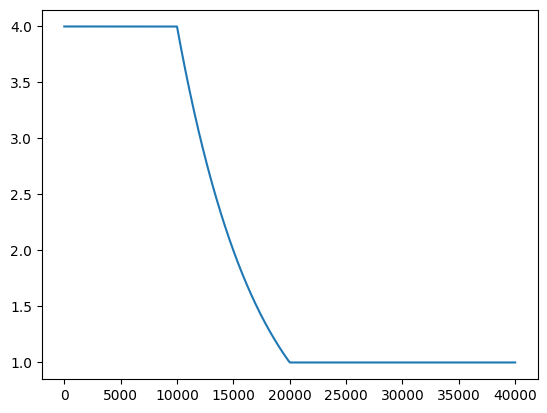

In [9]:

import matplotlib.pyplot as plt
import torch

initial_n = 4
final_n = 1
schedule_max_step = 10000

v=[]
for grad_step in range(40000):
    n = initial_n * (final_n/initial_n)**(min(torch.tensor(grad_step-10000).clip(0),schedule_max_step) / schedule_max_step)
    v.append(n)

plt.plot(v)


In [10]:
import torch
from torch import nn
from torch.nn import functional as F

from nosaveddata import *

class Quantizer1d(nn.Module):
    def __init__(self,
                 num_embeddings=256,
                 dim=512
                 ):
        super(Quantizer1d, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, dim)
    
    def forward(self, x):
        B, T, C = x.shape
        
        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1)).view(B,T,C)
        print(f"{min_encoding_indices.shape, min_encoding_indices}")
        
        commmitment_loss = ((quant_out.detach() - x) ** 2).mean((1,2))
        codebook_loss = ((quant_out - x.detach()) ** 2).mean((1,2))
        quantize_losses = {
            'codebook_loss' : codebook_loss,
            'commitment_loss' : commmitment_loss
        }
        quant_out = x + (quant_out - x).detach()
        min_encoding_indices = min_encoding_indices.contiguous().view((B,-1))
        return quant_out, quantize_losses, min_encoding_indices

    def forward_idx(self, x, idx):
        B, T, C = x.shape
        
        
        quant_out = torch.index_select(self.embedding.weight, 0, idx.view(-1)).view(B,T,C)
        
        print(f"{x.shape}")
        commmitment_loss = ((quant_out.detach() - x) ** 2).mean((1,2))
        codebook_loss = ((quant_out - x.detach()) ** 2).mean((1,2))
        quantize_losses = {
            'codebook_loss' : codebook_loss,
            'commitment_loss' : commmitment_loss
        }
        quant_out = x + (quant_out - x).detach()
        return quant_out, quantize_losses

quant = Quantizer1d(256,512)

x = torch.randn(32,1,512)
idx = torch.randint(0,256,(32,))[:,None]

a, b, c  = quant(x)

x, loss = quant.forward_idx(x, idx)

loss['codebook_loss'].shape

(torch.Size([32, 1]), tensor([[147],
        [189],
        [233],
        [ 13],
        [215],
        [226],
        [ 11],
        [141],
        [ 11],
        [243],
        [180],
        [ 56],
        [  6],
        [215],
        [161],
        [ 13],
        [ 88],
        [154],
        [ 11],
        [ 97],
        [ 60],
        [189],
        [ 39],
        [141],
        [150],
        [189],
        [115],
        [212],
        [189],
        [141],
        [ 11],
        [ 11]]))
torch.Size([32, 1, 512])


torch.Size([32])

In [11]:
import torch
from torch import nn
from torch.nn import functional as F

from nosaveddata import *

seed_np_torch(42)

a = torch.randn(38,2048)

b = nn.Embedding(38,2048)

state_dict = {'weight': a}

b.load_state_dict(state_dict)

c = torch.randint(0,38,(4,))

b(c), c, a[26]

(tensor([[-0.9774,  0.0935, -0.3474,  ...,  0.1858,  0.9352,  0.8609],
         [ 0.4313, -0.9067,  0.3586,  ...,  2.5234,  1.3809,  0.4820],
         [ 0.9409, -0.5029, -0.8184,  ..., -0.7990, -1.3363,  1.2311],
         [-0.7292,  0.3482, -0.3422,  ...,  1.2561,  0.0179, -2.1140]],
        grad_fn=<EmbeddingBackward0>),
 tensor([26,  9, 37, 35]),
 tensor([-0.9774,  0.0935, -0.3474,  ...,  0.1858,  0.9352,  0.8609]))

In [12]:
torch.tensor([[2]]).item()

2

In [13]:
1000 in range(999,1001)

True

In [14]:
import torch

a=torch.arange(10)

a.topk(3,-1)

torch.return_types.topk(
values=tensor([9, 8, 7]),
indices=tensor([9, 8, 7]))

In [15]:
import torch

# Assuming you have 5 vectors stored in a tensor called 'vectors'
#vectors = torch.randn(5, 10)  # Assuming each vector has size 10


# Compute pairwise distances between all vectors

def get_highest_l1_vectors(vectors, ammount=300):
    distances = torch.cdist(vectors, vectors)
    
    # Initialize a list to store the sampled indices
    sampled_indices = []
    
    # Start by randomly selecting the first index
    sampled_indices.append(torch.randint(0, vectors.size(0), (1,)).item())
    
    # Repeat until you have sampled 3 vectors
    while len(sampled_indices) < ammount:
        # Compute the distances from the already sampled vectors to all others
        sampled_distances = distances[sampled_indices, :].min(dim=0).values
        
        # Select the index with the maximum distance as the next sampled index
        next_index = sampled_distances.argmax().item()
        # Add the index to the list of sampled indices
        sampled_indices.append(next_index)
    
    # Extract the sampled vectors
    return vectors[sampled_indices], sampled_indices

vectors = torch.randn(300, 2048)
print(f"{vectors.shape}")

sampled_vectors, sampled_indices = get_highest_l1_vectors(vectors)

print("Sampled Vectors:")
print(f"{sampled_indices}")
print(sampled_vectors)


torch.Size([300, 2048])
Sampled Vectors:
[299, 106, 229, 18, 244, 17, 48, 173, 194, 133, 224, 222, 142, 163, 206, 51, 201, 216, 180, 268, 245, 97, 22, 160, 243, 121, 237, 66, 171, 172, 123, 170, 77, 120, 4, 149, 254, 57, 6, 74, 131, 85, 141, 205, 47, 252, 112, 127, 193, 132, 187, 87, 255, 39, 235, 108, 276, 214, 125, 43, 99, 79, 72, 19, 10, 162, 115, 81, 140, 179, 269, 83, 210, 75, 297, 52, 110, 55, 295, 174, 135, 288, 105, 178, 155, 184, 287, 271, 259, 136, 67, 24, 147, 5, 182, 257, 291, 62, 208, 42, 238, 60, 227, 148, 262, 294, 196, 27, 26, 146, 176, 200, 53, 138, 212, 128, 8, 247, 242, 199, 230, 107, 0, 63, 215, 263, 258, 68, 185, 246, 168, 251, 165, 188, 1, 65, 3, 228, 102, 253, 78, 167, 175, 145, 69, 261, 264, 30, 23, 154, 104, 159, 31, 211, 248, 191, 50, 226, 41, 93, 256, 21, 282, 113, 122, 25, 28, 234, 114, 213, 281, 296, 284, 103, 272, 198, 20, 240, 82, 220, 189, 290, 143, 278, 169, 9, 2, 118, 13, 58, 90, 7, 209, 111, 37, 280, 283, 249, 86, 46, 195, 275, 223, 34, 95, 130, 207, 

In [16]:
from diffusers import DPMSolverMultistepScheduler 
noise_scheduler = DPMSolverMultistepScheduler(num_train_timesteps=1000, beta_start=0.00085, beta_end=0.012, use_karras_sigmas=False, solver_order=2)

idx=10
noise_scheduler.alpha_t[idx], (1-noise_scheduler.alpha_t[idx]).sqrt(), (1-noise_scheduler.alphas_cumprod[idx]).sqrt()

(tensor(0.9950), tensor(0.0705), tensor(0.0996))

In [17]:
import torch
from torch import nn
from torch.nn import functional as F

from nosaveddata import *


def get_patches(x, patch_shape):
    c, (h, w) = x.shape[1], patch_shape
    
    return x.unfold(2,h,1).unfold(3,w,1).transpose(1,3).reshape(-1,c,h,w).float()

def get_whitening_parameters(patches):
    n,c,h,w = patches.shape
    patches_flat = patches.view(n, -1)
    est_patch_covariance = (patches_flat.T @ patches_flat) / n
    
    eigenvalues, eigenvectors = torch.linalg.eigh(est_patch_covariance, UPLO='U')
    
    return eigenvalues.flip(0).view(-1, 1, 1, 1), eigenvectors.T.reshape(c*h*w,c,h,w).flip(0)

def init_whitening_conv(layer, train_set, eps=5e-4):
    patches = get_patches(train_set, patch_shape=layer.weight.data.shape[2:])
    
    eigenvalues, eigenvectors = get_whitening_parameters(patches)
    
    eigenvectors_scaled = eigenvectors / torch.sqrt(eigenvalues + eps)
    layer.weight.data[:] = torch.cat((eigenvectors_scaled, -eigenvectors_scaled))
    layer.weight.requires_grad=False




class IMPALA_Resnet_Whitened(nsd_Module):
    def __init__(self, first_channels=12, scale_width=1, norm=True, init=init_partial_dirac, act=nn.SiLU()):
        super().__init__()
        # lhs 2 is because we use concatenate positive and negative eigenvectors, 3 is the kernel size
        self.whitened_channels = 2 * first_channels * 3**2
        
        self.cnn = nn.Sequential(self.whitened_block(first_channels, 16*scale_width),
                                 self.get_block(16*scale_width, 32*scale_width),
                                 self.get_block(32*scale_width, 32*scale_width, last_relu=True))
        
        self.cnn[0][1].apply(init)
        params_count(self, 'IMPALA ResNet')

    def whitened_block(self, in_hiddens, out_hiddens, last_relu=False):
        
        blocks = nn.Sequential(DQN_Conv(in_hiddens, self.whitened_channels, 3, 1, 1, max_pool=True, act=self.act, norm=self.norm, init=self.init),
                               nn.Conv2d(self.whitened_channels,out_hiddens, 1, padding=0, stride=1),
                               Residual_Block(out_hiddens, out_hiddens, norm=self.norm, act=self.act, init=self.init),
                               Residual_Block(out_hiddens, out_hiddens, norm=self.norm, act=self.act, init=self.init, out_act=self.act if last_relu else nn.Identity())
                              )
        
        return blocks
    
    def get_block(self, in_hiddens, out_hiddens, last_relu=False):
        
        blocks = nn.Sequential(DQN_Conv(in_hiddens, out_hiddens, 3, 1, 1, max_pool=True, act=self.act, norm=self.norm, init=self.init),
                               Residual_Block(out_hiddens, out_hiddens, norm=self.norm, act=self.act, init=self.init),
                               Residual_Block(out_hiddens, out_hiddens, norm=self.norm, act=self.act, init=self.init, out_act=self.act if last_relu else nn.Identity())
                              )
        
        return blocks
        
    def forward(self, X):
        return self.cnn(X)


x=torch.randn(500,12,96,72)
IMPALA_Resnet(12,scale_width=4)
network = IMPALA_Resnet_Whitened(12,scale_width=4)

init_whitening_conv(network.cnn[0][0].conv[0], x)





IMPALA ResNet Parameters: 1.56M
IMPALA ResNet Parameters: 1.59M


In [18]:
steps=40000
k=5
sched = 0.95**k * (torch.arange(steps+1) / steps)**3

sched[::500]

tensor([0.0000e+00, 1.5113e-06, 1.2090e-05, 4.0805e-05, 9.6723e-05, 1.8891e-04,
        3.2644e-04, 5.1837e-04, 7.7378e-04, 1.1017e-03, 1.5113e-03, 2.0115e-03,
        2.6115e-03, 3.3203e-03, 4.1470e-03, 5.1006e-03, 6.1902e-03, 7.4250e-03,
        8.8138e-03, 1.0366e-02, 1.2090e-02, 1.3996e-02, 1.6092e-02, 1.8388e-02,
        2.0892e-02, 2.3614e-02, 2.6562e-02, 2.9747e-02, 3.3176e-02, 3.6859e-02,
        4.0805e-02, 4.5023e-02, 4.9522e-02, 5.4311e-02, 5.9400e-02, 6.4797e-02,
        7.0511e-02, 7.6551e-02, 8.2928e-02, 8.9648e-02, 9.6723e-02, 1.0416e-01,
        1.1197e-01, 1.2016e-01, 1.2874e-01, 1.3772e-01, 1.4710e-01, 1.5691e-01,
        1.6714e-01, 1.7780e-01, 1.8891e-01, 2.0047e-01, 2.1250e-01, 2.2500e-01,
        2.3797e-01, 2.5144e-01, 2.6541e-01, 2.7988e-01, 2.9487e-01, 3.1039e-01,
        3.2644e-01, 3.4303e-01, 3.6018e-01, 3.7789e-01, 3.9618e-01, 4.1504e-01,
        4.3449e-01, 4.5454e-01, 4.7520e-01, 4.9647e-01, 5.1837e-01, 5.4091e-01,
        5.6409e-01, 5.8792e-01, 6.1241e-

In [19]:
class LookaheadState:
    def __init__(self, net, steps, k=5):
        self.k=k
        self.net_ema = {k: v.clone() for k, v in net.state_dict().items()}
        self.sched = 0.95**k * (torch.arange(steps+1) / steps)**3

    def update(self, net, step):
        decay = self.sched[step].item()
        if step%self.k==0:
            for ema_param, net_param in zip(self.net_ema.values(), net.state_dict().values()):
                ema_param.lerp_(net_param, 1-decay)
                net_param.copy_(ema_param)
                
    def update_fixed_decay(self, net, decay, step):
        if step%self.k==0:
            for ema_param, net_param in zip(self.net_ema.values(), net.state_dict().values()):
                ema_param.lerp_(net_param, 1-decay)
                net_param.copy_(ema_param)

lookahead_state = LookaheadState(network, 40000)

lookahead_state.update(network, 8)

def Triangle_Scheduler(optimizer, steps, start=0.2, end=0.07, peak=0.23):
    def triangle(steps, start, end, peak):
        xp = torch.tensor([0, int(peak * steps), steps])
        fp = torch.tensor([start, 1, end])
        x = torch.arange(1+steps)
        m = (fp[1:] - fp[:-1]) / (xp[1:] - xp[:-1])
        b = fp[:-1] - (m * xp[:-1])
        indices = torch.sum(torch.ge(x[:, None], xp[None, :]), 1) - 1
        indices = torch.clamp(indices, 0, len(m) - 1)
        return m[indices] * x + b[indices]
    lr_schedule = triangle(steps, start, end, peak)
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: lr_schedule[i])

momentum=0.9
lr = 0.1 / (1+1/(1-momentum))
print(f"{lr}")

optim = torch.optim.SGD(network.parameters(), lr=lr, weight_decay=0.1, momentum=momentum, nesterov=True)

sched = Triangle_Scheduler(optim, 40000)

print(f"{optim.param_groups[0]['lr']}")
for i in range(int(40000*0.23)):
    sched.step()
print(f"{optim.param_groups[0]['lr']}")

total_train_steps=40000


lookahead_state.update(network, 8)

0.00909090909090909
0.001818181830458343
0.00909090880304575


C:\Users\sneep\anaconda3\envs\python_\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [20]:
lr = 11.5/1024# * (1 + 1 / (1 - 0.85))

lr, 0.0153/(1 + 1 / (1 - 0.85))*lr

(0.01123046875, 2.2412109374999998e-05)

In [21]:
class Conv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding='same', bias=False):
        super().__init__(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)

    def reset_parameters(self):
        super().reset_parameters()
        if self.bias is not None:
            self.bias.data.zero_()
        w = self.weight.data
        torch.nn.init.dirac_(w[:w.size(1)])

def init_partial_dirac(module):
    if type(module) in (nn.Linear, nn.Conv2d, nn.Conv1d, nn.Conv3d):
        w = module.weight.data
        
        nn.init.dirac_(module.weight[:w.shape[1]])
        nn.init.xavier_uniform_(module.weight[w.shape[1]:], gain=1)

        if module.bias is not None:
            nn.init.zeros_(module.bias)
            

model = Conv(16,32)
model.apply(init_partial_dirac)
last_relu=False
act=nn.ReLU()

in_hiddens=16
out_hiddens=32

norm = False
model = nn.Sequential(DQN_Conv(in_hiddens, out_hiddens, 3, 1, 1, max_pool=True, act=act, norm=norm, init=init_partial_dirac),
                               Residual_Block(out_hiddens, out_hiddens, norm=norm, act=act, init=init_partial_dirac),
                               Residual_Block(out_hiddens, out_hiddens, norm=norm, act=act, init=init_partial_dirac, out_act=act if last_relu else nn.Identity()),
                               MLP(512,512)
                              )

In [22]:
import re
from unidecode import unidecode
from phonemizer import phonemize
from phonemizer.backend import EspeakBackend
backend = EspeakBackend('en-us', preserve_punctuation=True, with_stress=True)

def english_cleaners2(text):
  '''Pipeline for English text, including abbreviation expansion. + punctuation + stress'''
  text = unidecode(text)
  print(f"{text}")
  text = text.lower()
    
  print(f"{text}")
  phonemes = backend.phonemize([text], strip=True)[0]
  phonemes = collapse_whitespace(phonemes)
  return phonemes

english_cleaners2("Olá doutor")


RuntimeError: espeak not installed on your system

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10,30)
    
    def forward(self, x):
        return self.linear(x)

model = Model()
model = torch.compile(model)

x=torch.randn(1,10)
model(x)


In [ ]:
import spacy
import epitran

# Carregar o modelo em português
nlp = spacy.load('pt_core_news_sm')

# Texto de exemplo
texto = "O cachorro correu pelo parque."

#texto = "Exemplo de texto para fonemização."

doc = nlp(texto)
for token in doc:
    try:
        fonemas = fonemizar_texto(token.text)
        print(f'{token.text} -> {fonemas}')
    except Exception as e:
        pass


fonemizar_texto(tokens)



In [ ]:
from nosaveddata import *
import torch
from torch import nn

class Network(nn.Module):
    def __init__(self, len_state, num_quant, num_actions):
        nn.Module.__init__(self)
       
        self.num_quant = num_quant
        self.num_actions = num_actions
       
        self.layer1 = nn.Linear(len_state, 256)
        self.layer2 = nn.Linear(256, num_actions*num_quant)  

    def forward(self, x):
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        return x.view(-1, self.num_actions, self.num_quant)
   
    def select_action(self, state, eps):
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor([state])    
        action = torch.randint(0, 2, (1,))
        if random.random() > eps:
            action = self.forward(state).mean(2).max(1)[1]
        return int(action)
   

eps_start, eps_end, eps_dec = 0.9, 0.1, 500
eps = lambda steps: eps_end + (eps_start - eps_end) * np.exp(-1. * steps / eps_dec)

Z = Network(len_state=8, num_quant=2, num_actions=7)
Ztgt = Network(len_state=8, num_quant=2, num_actions=7)
Ztgt.load_state_dict(Z.state_dict())
tau = torch.Tensor((2 * np.arange(Z.num_quant) + 1) / (2.0 * Z.num_quant)).view(1, -1)

batch_size=3

def huber(x, k=1.0):
    return torch.where(x.abs() < k, 0.5 * x.pow(2), k * (x.abs() - 0.5 * k))

next_states = torch.randn(batch_size,8)
states = next_states + torch.randn(batch_size,8)*0.01

gamma=0.997
rewards=torch.ones(batch_size,1)


theta = Z(states)
print(f"{theta.shape, theta.mean(-1).argmax(-1)}")
theta = theta[np.arange(batch_size), theta.mean(2).max(1)[1]]


Znext = Ztgt(next_states).detach()
Znext_max = Znext[np.arange(batch_size), Znext.mean(2).max(1)[1]]

print(f"{Znext.mean(2).max(1)[1]}")

Ttheta = rewards + gamma  * Znext_max

print(f"{Ttheta.t()[..., None].shape, theta.shape}")

diff = Ttheta.t()[..., None] - theta

loss = huber(diff) * (tau - (diff.detach() < 0).float()).abs()


loss, diff, Ttheta, theta

In [ ]:
from nosaveddata import *
import torch
from torch import nn

a=torch.arange(2,device='cuda').long()[:,None].repeat_interleave(15,0)

a,torch.zeros(6,1,device='cuda').long()

In [ ]:
import math
import torch

p1 = 0.6697
p2 = 0.6649
n = 10000

def statistical_difference(p1, p2, n):
    
    d=torch.tensor(p1-p2).abs()

    std = 1.65 * math.sqrt((p1*(1-p1) + p2*(1-p2))/n)
    
    difference = torch.tensor([d-std, d+std])
    
    return difference.sort()[0]

print(statistical_difference(0.834, 0.831, 100000))

In [ ]:
from nosaveddata import *
import torch
from torch import nn

class IMPALA_Resnet(nn.Module):
    def __init__(self, first_channels=12, scale_width=1, norm=True, init=init_relu, act=nn.SiLU()):
        super().__init__()
        self.norm=norm
        self.init=init
        self.act =act
        
        self.cnn = nn.Sequential(self.get_block(first_channels, 16*scale_width),
                                 self.get_block(16*scale_width, 32*scale_width),
                                 self.get_block(32*scale_width, 32*scale_width, last_relu=True))
        params_count(self, 'IMPALA ResNet')
    def get_block(self, in_hiddens, out_hiddens, last_relu=False):
        
        blocks = nn.Sequential(DQN_Conv(in_hiddens, out_hiddens, 3, 1, 1, max_pool=True, act=self.act, norm=self.norm, init=self.init),
                               Residual_Block(out_hiddens, out_hiddens, norm=self.norm, act=self.act, init=self.init),
                               Residual_Block(out_hiddens, out_hiddens, norm=self.norm, act=self.act, init=self.init, out_act=self.act if last_relu else nn.Identity())
                              )
        
        return blocks
        
    def forward(self, X):
        return self.cnn(X)


class IMPALA_YY(nn.Module):
    def __init__(self, first_channels=12, scale_width=1, norm=True, init=init_relu, act=nn.SiLU()):
        super().__init__()
        self.norm=norm
        self.init=init
        self.act =act

        self.yin = self.get_yin(first_channels, 16*scale_width, 32*scale_width)
        
        self.yang = self.get_yang(first_channels, 16*scale_width)
                                 
        self.head = nn.Sequential(self.get_yang(16*scale_width, 32*scale_width),
                                  self.get_yang(32*scale_width, 32*scale_width, last_relu=True))
        
        params_count(self, 'IMPALA ResNet')

    def get_yin(self, in_hiddens, hiddens, out_hiddens):
        blocks = nn.Sequential(DQN_Conv(1, hiddens, 3, 1, 1, max_pool=True, act=self.act, norm=self.norm, init=self.init),
                               Residual_Block(hiddens, hiddens, norm=self.norm, act=self.act, init=self.init),
                               #DQN_Conv(hiddens, out_hiddens, 3, 1, 1, max_pool=True, act=self.act, norm=self.norm, init=self.init),
                               #Residual_Block(out_hiddens, out_hiddens, norm=self.norm, act=self.act, init=self.init),
                               #Residual_Block(out_hiddens, out_hiddens, norm=self.norm, act=self.act, init=self.init)
                              )
        return blocks          
        
    def get_yang(self, in_hiddens, out_hiddens, last_relu=False):
        
        blocks = nn.Sequential(DQN_Conv(in_hiddens, out_hiddens, 3, 1, 1, max_pool=True, act=self.act, norm=self.norm, init=self.init),
                               Residual_Block(out_hiddens, out_hiddens, norm=self.norm, act=self.act, init=self.init),
                               Residual_Block(out_hiddens, out_hiddens, norm=self.norm, act=self.act, init=self.init, out_act=self.act if last_relu else nn.Identity())
                              )
        
        return blocks
    
    def forward(self, X):

        y = self.yin(X[:,-3:].mean(-3)[:,None])
        x = self.yang(X)
        
        X = x*(1-y) + x + y
        
        return self.head(X)

model = IMPALA_Resnet(scale_width=4)
x=torch.randn(32,12,96,72)
model2 = IMPALA_YY(scale_width=4)

model(x).shape, model2(x).shape

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from nosaveddata import *

seed_np_torch(42)

def network_ema(target_network, new_network, alpha=0.5):
    for (param_name, param_target), param_new  in zip(target_network.cuda().named_parameters(), new_network.parameters()):
        if 'ln' in param_name: #layer norm
            param_target.data = param_new.data.clone()
        else:
            param_target.data = alpha * param_target.data + (1 - alpha) * param_new.data.clone()


class Modeld(nsd_Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(10,32)
        self.ln = nn.LayerNorm(32)

    def forward(self,X):
        return self.ln(self.linear(X))

m = Modeld().cuda()
m_rand= Modeld().cuda()


optim=torch.optim.AdamW(m.parameters(), lr=1e-4)

for i in range(4000):
    x=torch.randn(1,10).cuda()
    
    loss = m(x).sum()
    loss.backward()
    
    optim.step()
    optim.zero_grad()

network_ema(m,m_rand)

m.ln.weight, m.linear.weight

In [ ]:
from nosaveddata import *
import torch
from torch import nn

model = nn.Linear(10,2).cuda()
model.apply(init_xavier)
model2 = nn.Linear(10,2).cuda()
network_ema(model, model2, 0)
model.apply(init_xavier)

model.weight.data==model2.weight.data

<h1>Preprocessing</h1>

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import os, glob
from nosaveddata import *


import torchvision
from torchvision import transforms

paths = glob.glob('C:/Users/Augusto/Python/PyTorch/RL/mc_data/4/2023_01_09_14_48_09_100636/*.jpg')
path = 'C:/Users/Augusto/Python/PyTorch/RL/mc_data/4/2023_01_09_14_48_09_100636/7,0,0,0,0,0,0,0,0,0,0,0,0,3,0,.jpg'



tfms = transforms.Compose([
                           transforms.Resize((96, 72)),
                           transforms.ToTensor()
                        ])

img = Image.open(path)
imgs=[]
for p in paths:
    imgs.append(tfms(Image.open(p)))
imgs=torch.stack(imgs)

print(imgs.shape)



imgs, augments_applied = preprocess_iwm_no_solarize(imgs)
    


#plt.imshow(img_tfms)
plot_imgs(imgs.permute(0,2,3,1))
augments_applied

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

from nosaveddata import *



def gray_scale_stacked(X, p=0.2, stacks=4):
    # Input: Tensor T e (B,C,T,D)
    
    probs = get_img_preprocessing_prob(X.shape[0], p, X.device)
    stacked_probs = probs.repeat_interleave(stacks,0)
    X = X.view(-1,X.shape[1]//stacks,*X.shape[-2:])
    
    gray_img = X.mean(1,keepdim=True).expand(-1,3,-1,-1)
    
    X = (1-stacked_probs)*X + stacked_probs*gray_img
    
    return X.view(X.shape[0]//stacks, -1, *X.shape[-2:]), probs.squeeze()

def gaussian_blur(X, p=0.2, stacks=4, sigma_min=0.1, sigma_max=2):
    # Input: Tensor T e (B,C,T,D)
    
    probs = get_img_preprocessing_prob(X.shape[0], p, X.device)
    tfms = transforms.GaussianBlur(3, (sigma_min, sigma_max))
    
    blurred = tfms(X)
    X = (1-probs)*X + probs*blurred
    
    return X, probs.squeeze()

def solarization_stacked(X, p=0.2, stacks=4):
    # Input: Tensor T e (B,C,T,D)

    probs = get_img_preprocessing_prob(X.shape[0], p, X.device)
    stacked_probs = probs.repeat_interleave(stacks,0)
    
    X = X.view(-1,X.shape[1]//stacks,*X.shape[-2:])
    
    tfms = transforms.RandomSolarize(0,p=1) # This prob is applied over all the batch or no image at all
    
    solarized = tfms(X)
    X = (1-stacked_probs)*X + stacked_probs*solarized
    
    return X.view(X.shape[0]//stacks, -1, *X.shape[-2:]), probs.squeeze()


def preprocess_iwm_stacked(imgs, p=0.2, stacks=4):
    # Applies the same preprocessing for all images in the sequence, but separated by each beach
    augments_applied=[]
    
    imgs, augmented = gray_scale_stacked(imgs, p, stacks)
    augments_applied.append(augmented)
    
    imgs, augmented = gaussian_blur_stacked(imgs, p, stacks)
    augments_applied.append(augmented)
    
    imgs, augmented = solarization_stacked(imgs, p, stacks)
    augments_applied.append(augmented)
    
    augments_applied = torch.stack(augments_applied,1)
    return imgs, augments_applied

preprocess_iwm_stacked(torch.randn(32,12,96,72, device='cuda'))[0].shape

In [ ]:
plot_img(imgs[-1].permute(1,2,0))

<h1>DiT</h1>

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

from nosaveddata import *

unet = UNet_DiT_S_4(in_channels=4).cuda()
x=torch.randn(32,4,32,32).cuda()
c=torch.randn(32,384).cuda()
t=torch.randint(0,1000,(32,)).cuda()
unet(x,t).shape

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

from nosaveddata import *


model = DiT_Transformer(128, 8, 8, 108).cuda()

X = torch.randn(16,108,128).cuda()
c = torch.randn(16,128).cuda()

model(X, c).shape

In [ ]:
import torch

list(torch.tensor([1,2,3,4]).split(1))

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

from nosaveddata import *

model = UNet_DiT_1D(2048, 256, 2, 2048//64, seq_len=5).cuda()

X = torch.randn(16,5,2048).cuda()
t=torch.randint(0,1000,(16,)).cuda()
c = torch.randn(16,256).cuda()

model(X, t, c).shape